In [1]:
import os  
import numpy as np
from scipy import *
from numpy import dot, multiply, diag, power, pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv,norm
from scipy.linalg import svd, svdvals 
import scipy.io as sio  
import re  
import warnings
warnings.filterwarnings("ignore")

import torch 
from torch.autograd import Variable
from torch.optim import Adam, SGD   
import torch.optim as optim
import matplotlib.pyplot as plt 

from utility import *
from model import *

In [2]:
# parameters
savename = 'Trade_physics_test'  
n_class =87
dim_input = 1
# parameters for CNN  
gamma = 0.05 
batch_size =70
display_step = 100  
num_bus =68 
learning_rate = 0.01               
rootPath =  './data'
trainName = 'train_data.mat'  
testName = 'testing_sigPQ_perturb_1' 
scenario = 1 # choose 1 or 2 denoting the two kinds of testing data in the corresponding scenario 
model_dir  = './saved_model' 
epsilon = 0.01
k = 7
alpha = 0.01 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
weight_decay = 5e-5
epochs =1500  
dim_input = 1 
dim_hidden = [4,8,8,8]
nclass = 87
seed = 1 
early_stop = False
lam  = 0.1  

In [8]:
# load data
data = sio.loadmat(os.path.join(rootPath, trainName))
linedata, Y,  line_neib = loadline(rootPath  ) 
Y_ri = np.r_[np.c_[Y.real, -Y.imag], np.c_[ Y.imag, Y.real ]].T 
w = choose_w(linedata,2)  
train_x,    train_labels, train_num  = load_all_data_VI(w,rootPath, trainName ) 
cur_up_limit, cur_down_limit = current_dist(rootPath) 
vol_up_limit, vol_down_limit = vol_dist(rootPath) 
up_limit = epsilon * np.r_[vol_up_limit, cur_up_limit]
down_limit = epsilon *np.r_[vol_down_limit, cur_down_limit]

 
 

In [4]:
def main(seed, dim_input, dim_hidden):
    np.random.seed( seed)
    torch.manual_seed( seed) 
    
    model = Net(dim_input, dim_hidden, nclass) 
    model.apply(weights_init) 
    model.train()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    criterion = CrossEntropyLoss()   
    pre_robust_acc = 0. 
    x_train, y_train = Variable(train_x)  , Variable(train_labels) 
    train_best = float('Inf') 
    train_loss_list= []
    for epoch in range( epochs):  
        train_acc = 0
        train_n = 0 
        train_loss = 0 
        for i in range(int(train_x.shape[0] / batch_size)):
            id_train = np.random.choice(train_x.shape[0], batch_size, replace= False) 
            optimizer.zero_grad() 
            loss, output  = trades_loss(  model=model,
                               x_natural=x_train[id_train],
                               y=y_train[id_train],
                                        Y_ri = Y_ri, 
                               optimizer=optimizer,
                               up_limit = up_limit,
                               down_limit = down_limit,
                               step_size= alpha, 
                               perturb_steps= k,
                                        gamma = gamma,
                               lam= lam)   
            loss.backward()
            optimizer.step() 
            train_loss_list.append(loss.item())   
            train_acc  = (output.max(1)[1] == y_train[id_train]).sum().item() *100/np.shape(id_train)[0]  
            train_n += y_train[id_train].size(0)
            if epoch%5 == 0: 
                print('Training Epoch: {}, [{}/{}, {:.0f}%], loss is {:.6f}'\
                      .format(epoch  , i * batch_size, train_x.shape[0],\
                              train_acc  , loss.item()  )) 
                if train_loss < train_best:
                    print('best model')
                    print('Epoch', epoch)
                    train_best += loss.item()
                    torch.save(model.state_dict(), os.path.join(model_dir,  'model-' + savename + '.pt'))
                    torch.save(optimizer.state_dict(), os.path.join(model_dir, 'opt-' + savename + '.tar'))
            train_loss_list.append(loss.item())  
        if not early_stop:
            best_state_dict = model.state_dict()  
    plt.plot(train_loss_list)
    return train_loss_list , train_best 
 

Training Epoch: 0, [0/560, 1%], loss is 4.604418
best model
Epoch 0
Training Epoch: 0, [70/560, 3%], loss is 4.493111
best model
Epoch 0
Training Epoch: 0, [140/560, 7%], loss is 4.434281
best model
Epoch 0
Training Epoch: 0, [210/560, 3%], loss is 4.296464
best model
Epoch 0
Training Epoch: 0, [280/560, 3%], loss is 4.267357
best model
Epoch 0
Training Epoch: 0, [350/560, 3%], loss is 4.235160
best model
Epoch 0
Training Epoch: 0, [420/560, 3%], loss is 4.059815
best model
Epoch 0
Training Epoch: 0, [490/560, 10%], loss is 3.997657
best model
Epoch 0
Training Epoch: 5, [0/560, 33%], loss is 2.435199
best model
Epoch 5
Training Epoch: 5, [70/560, 37%], loss is 2.233573
best model
Epoch 5
Training Epoch: 5, [140/560, 40%], loss is 2.220727
best model
Epoch 5
Training Epoch: 5, [210/560, 43%], loss is 2.104862
best model
Epoch 5
Training Epoch: 5, [280/560, 30%], loss is 2.273734
best model
Epoch 5
Training Epoch: 5, [350/560, 49%], loss is 1.921524
best model
Epoch 5
Training Epoch: 5, 

Training Epoch: 70, [210/560, 79%], loss is 0.230199
best model
Epoch 70
Training Epoch: 70, [280/560, 77%], loss is 0.196755
best model
Epoch 70
Training Epoch: 70, [350/560, 77%], loss is 0.214168
best model
Epoch 70
Training Epoch: 70, [420/560, 77%], loss is 0.233225
best model
Epoch 70
Training Epoch: 70, [490/560, 76%], loss is 0.294893
best model
Epoch 70
Training Epoch: 75, [0/560, 77%], loss is 0.159390
best model
Epoch 75
Training Epoch: 75, [70/560, 67%], loss is 0.236300
best model
Epoch 75
Training Epoch: 75, [140/560, 76%], loss is 0.247460
best model
Epoch 75
Training Epoch: 75, [210/560, 69%], loss is 0.290276
best model
Epoch 75
Training Epoch: 75, [280/560, 77%], loss is 0.329029
best model
Epoch 75
Training Epoch: 75, [350/560, 79%], loss is 0.129769
best model
Epoch 75
Training Epoch: 75, [420/560, 79%], loss is 0.208517
best model
Epoch 75
Training Epoch: 75, [490/560, 73%], loss is 0.281032
best model
Epoch 75
Training Epoch: 80, [0/560, 69%], loss is 0.447921
bes

Training Epoch: 140, [210/560, 87%], loss is 0.101776
best model
Epoch 140
Training Epoch: 140, [280/560, 80%], loss is 0.138353
best model
Epoch 140
Training Epoch: 140, [350/560, 87%], loss is 0.072674
best model
Epoch 140
Training Epoch: 140, [420/560, 83%], loss is 0.103206
best model
Epoch 140
Training Epoch: 140, [490/560, 79%], loss is 0.164743
best model
Epoch 140
Training Epoch: 145, [0/560, 84%], loss is 0.095565
best model
Epoch 145
Training Epoch: 145, [70/560, 86%], loss is 0.187093
best model
Epoch 145
Training Epoch: 145, [140/560, 80%], loss is 0.113104
best model
Epoch 145
Training Epoch: 145, [210/560, 86%], loss is 0.101864
best model
Epoch 145
Training Epoch: 145, [280/560, 80%], loss is 0.075256
best model
Epoch 145
Training Epoch: 145, [350/560, 87%], loss is 0.159680
best model
Epoch 145
Training Epoch: 145, [420/560, 79%], loss is 0.141227
best model
Epoch 145
Training Epoch: 145, [490/560, 89%], loss is 0.062307
best model
Epoch 145
Training Epoch: 150, [0/560,

Training Epoch: 210, [210/560, 84%], loss is 0.065011
best model
Epoch 210
Training Epoch: 210, [280/560, 90%], loss is 0.077159
best model
Epoch 210
Training Epoch: 210, [350/560, 89%], loss is 0.073467
best model
Epoch 210
Training Epoch: 210, [420/560, 76%], loss is 0.142251
best model
Epoch 210
Training Epoch: 210, [490/560, 86%], loss is 0.103532
best model
Epoch 210
Training Epoch: 215, [0/560, 87%], loss is 0.097607
best model
Epoch 215
Training Epoch: 215, [70/560, 89%], loss is 0.083400
best model
Epoch 215
Training Epoch: 215, [140/560, 89%], loss is 0.080093
best model
Epoch 215
Training Epoch: 215, [210/560, 86%], loss is 0.075276
best model
Epoch 215
Training Epoch: 215, [280/560, 87%], loss is 0.049987
best model
Epoch 215
Training Epoch: 215, [350/560, 94%], loss is 0.043483
best model
Epoch 215
Training Epoch: 215, [420/560, 81%], loss is 0.073400
best model
Epoch 215
Training Epoch: 215, [490/560, 90%], loss is 0.070402
best model
Epoch 215
Training Epoch: 220, [0/560,

Training Epoch: 280, [210/560, 94%], loss is 0.087333
best model
Epoch 280
Training Epoch: 280, [280/560, 90%], loss is 0.049738
best model
Epoch 280
Training Epoch: 280, [350/560, 86%], loss is 0.082789
best model
Epoch 280
Training Epoch: 280, [420/560, 86%], loss is 0.104461
best model
Epoch 280
Training Epoch: 280, [490/560, 87%], loss is 0.077057
best model
Epoch 280
Training Epoch: 285, [0/560, 77%], loss is 0.126544
best model
Epoch 285
Training Epoch: 285, [70/560, 91%], loss is 0.080491
best model
Epoch 285
Training Epoch: 285, [140/560, 86%], loss is 0.141453
best model
Epoch 285
Training Epoch: 285, [210/560, 86%], loss is 0.116682
best model
Epoch 285
Training Epoch: 285, [280/560, 90%], loss is 0.061188
best model
Epoch 285
Training Epoch: 285, [350/560, 90%], loss is 0.065188
best model
Epoch 285
Training Epoch: 285, [420/560, 84%], loss is 0.083261
best model
Epoch 285
Training Epoch: 285, [490/560, 87%], loss is 0.059410
best model
Epoch 285
Training Epoch: 290, [0/560,

Training Epoch: 350, [210/560, 90%], loss is 0.090867
best model
Epoch 350
Training Epoch: 350, [280/560, 89%], loss is 0.076082
best model
Epoch 350
Training Epoch: 350, [350/560, 84%], loss is 0.083226
best model
Epoch 350
Training Epoch: 350, [420/560, 93%], loss is 0.047472
best model
Epoch 350
Training Epoch: 350, [490/560, 87%], loss is 0.078170
best model
Epoch 350
Training Epoch: 355, [0/560, 93%], loss is 0.049859
best model
Epoch 355
Training Epoch: 355, [70/560, 83%], loss is 0.086980
best model
Epoch 355
Training Epoch: 355, [140/560, 84%], loss is 0.073625
best model
Epoch 355
Training Epoch: 355, [210/560, 80%], loss is 0.261480
best model
Epoch 355
Training Epoch: 355, [280/560, 86%], loss is 0.095740
best model
Epoch 355
Training Epoch: 355, [350/560, 81%], loss is 0.139190
best model
Epoch 355
Training Epoch: 355, [420/560, 87%], loss is 0.084283
best model
Epoch 355
Training Epoch: 355, [490/560, 89%], loss is 0.067425
best model
Epoch 355
Training Epoch: 360, [0/560,

Training Epoch: 420, [210/560, 89%], loss is 0.074235
best model
Epoch 420
Training Epoch: 420, [280/560, 84%], loss is 0.075732
best model
Epoch 420
Training Epoch: 420, [350/560, 90%], loss is 0.038638
best model
Epoch 420
Training Epoch: 420, [420/560, 84%], loss is 0.070791
best model
Epoch 420
Training Epoch: 420, [490/560, 83%], loss is 0.075550
best model
Epoch 420
Training Epoch: 425, [0/560, 83%], loss is 0.080493
best model
Epoch 425
Training Epoch: 425, [70/560, 91%], loss is 0.047423
best model
Epoch 425
Training Epoch: 425, [140/560, 79%], loss is 0.101346
best model
Epoch 425
Training Epoch: 425, [210/560, 81%], loss is 0.082760
best model
Epoch 425
Training Epoch: 425, [280/560, 89%], loss is 0.064506
best model
Epoch 425
Training Epoch: 425, [350/560, 84%], loss is 0.096604
best model
Epoch 425
Training Epoch: 425, [420/560, 91%], loss is 0.051193
best model
Epoch 425
Training Epoch: 425, [490/560, 89%], loss is 0.059089
best model
Epoch 425
Training Epoch: 430, [0/560,

Training Epoch: 490, [210/560, 87%], loss is 0.057315
best model
Epoch 490
Training Epoch: 490, [280/560, 90%], loss is 0.062044
best model
Epoch 490
Training Epoch: 490, [350/560, 91%], loss is 0.041973
best model
Epoch 490
Training Epoch: 490, [420/560, 83%], loss is 0.074033
best model
Epoch 490
Training Epoch: 490, [490/560, 89%], loss is 0.050118
best model
Epoch 490
Training Epoch: 495, [0/560, 86%], loss is 0.063588
best model
Epoch 495
Training Epoch: 495, [70/560, 86%], loss is 0.052698
best model
Epoch 495
Training Epoch: 495, [140/560, 80%], loss is 0.094639
best model
Epoch 495
Training Epoch: 495, [210/560, 81%], loss is 0.058685
best model
Epoch 495
Training Epoch: 495, [280/560, 86%], loss is 0.077611
best model
Epoch 495
Training Epoch: 495, [350/560, 76%], loss is 0.106788
best model
Epoch 495
Training Epoch: 495, [420/560, 74%], loss is 0.133337
best model
Epoch 495
Training Epoch: 495, [490/560, 84%], loss is 0.054390
best model
Epoch 495
Training Epoch: 500, [0/560,

Training Epoch: 560, [210/560, 83%], loss is 0.075618
best model
Epoch 560
Training Epoch: 560, [280/560, 90%], loss is 0.058150
best model
Epoch 560
Training Epoch: 560, [350/560, 90%], loss is 0.050398
best model
Epoch 560
Training Epoch: 560, [420/560, 93%], loss is 0.038350
best model
Epoch 560
Training Epoch: 560, [490/560, 91%], loss is 0.054133
best model
Epoch 560
Training Epoch: 565, [0/560, 94%], loss is 0.022735
best model
Epoch 565
Training Epoch: 565, [70/560, 91%], loss is 0.050142
best model
Epoch 565
Training Epoch: 565, [140/560, 87%], loss is 0.053150
best model
Epoch 565
Training Epoch: 565, [210/560, 87%], loss is 0.050110
best model
Epoch 565
Training Epoch: 565, [280/560, 91%], loss is 0.041771
best model
Epoch 565
Training Epoch: 565, [350/560, 86%], loss is 0.093879
best model
Epoch 565
Training Epoch: 565, [420/560, 84%], loss is 0.072249
best model
Epoch 565
Training Epoch: 565, [490/560, 94%], loss is 0.054436
best model
Epoch 565
Training Epoch: 570, [0/560,

Training Epoch: 630, [140/560, 84%], loss is 0.069071
best model
Epoch 630
Training Epoch: 630, [210/560, 90%], loss is 0.065325
best model
Epoch 630
Training Epoch: 630, [280/560, 86%], loss is 0.183388
best model
Epoch 630
Training Epoch: 630, [350/560, 84%], loss is 0.109029
best model
Epoch 630
Training Epoch: 630, [420/560, 89%], loss is 0.061493
best model
Epoch 630
Training Epoch: 630, [490/560, 87%], loss is 0.080527
best model
Epoch 630
Training Epoch: 635, [0/560, 91%], loss is 0.052275
best model
Epoch 635
Training Epoch: 635, [70/560, 87%], loss is 0.063067
best model
Epoch 635
Training Epoch: 635, [140/560, 91%], loss is 0.063662
best model
Epoch 635
Training Epoch: 635, [210/560, 91%], loss is 0.029653
best model
Epoch 635
Training Epoch: 635, [280/560, 90%], loss is 0.052331
best model
Epoch 635
Training Epoch: 635, [350/560, 87%], loss is 0.046979
best model
Epoch 635
Training Epoch: 635, [420/560, 86%], loss is 0.079671
best model
Epoch 635
Training Epoch: 635, [490/56

Training Epoch: 700, [0/560, 89%], loss is 0.057722
best model
Epoch 700
Training Epoch: 700, [70/560, 89%], loss is 0.044111
best model
Epoch 700
Training Epoch: 700, [140/560, 93%], loss is 0.038735
best model
Epoch 700
Training Epoch: 700, [210/560, 91%], loss is 0.046605
best model
Epoch 700
Training Epoch: 700, [280/560, 94%], loss is 0.040448
best model
Epoch 700
Training Epoch: 700, [350/560, 90%], loss is 0.047890
best model
Epoch 700
Training Epoch: 700, [420/560, 91%], loss is 0.033833
best model
Epoch 700
Training Epoch: 700, [490/560, 87%], loss is 0.048881
best model
Epoch 700
Training Epoch: 705, [0/560, 93%], loss is 0.047441
best model
Epoch 705
Training Epoch: 705, [70/560, 94%], loss is 0.031645
best model
Epoch 705
Training Epoch: 705, [140/560, 90%], loss is 0.027992
best model
Epoch 705
Training Epoch: 705, [210/560, 87%], loss is 0.048911
best model
Epoch 705
Training Epoch: 705, [280/560, 93%], loss is 0.028123
best model
Epoch 705
Training Epoch: 705, [350/560, 

Training Epoch: 765, [420/560, 93%], loss is 0.033219
best model
Epoch 765
Training Epoch: 765, [490/560, 91%], loss is 0.050965
best model
Epoch 765
Training Epoch: 770, [0/560, 87%], loss is 0.048576
best model
Epoch 770
Training Epoch: 770, [70/560, 87%], loss is 0.069250
best model
Epoch 770
Training Epoch: 770, [140/560, 94%], loss is 0.033839
best model
Epoch 770
Training Epoch: 770, [210/560, 91%], loss is 0.037842
best model
Epoch 770
Training Epoch: 770, [280/560, 90%], loss is 0.050727
best model
Epoch 770
Training Epoch: 770, [350/560, 87%], loss is 0.054102
best model
Epoch 770
Training Epoch: 770, [420/560, 90%], loss is 0.048307
best model
Epoch 770
Training Epoch: 770, [490/560, 93%], loss is 0.028827
best model
Epoch 770
Training Epoch: 775, [0/560, 90%], loss is 0.046601
best model
Epoch 775
Training Epoch: 775, [70/560, 90%], loss is 0.047230
best model
Epoch 775
Training Epoch: 775, [140/560, 84%], loss is 0.054607
best model
Epoch 775
Training Epoch: 775, [210/560, 

Training Epoch: 835, [350/560, 93%], loss is 0.037968
best model
Epoch 835
Training Epoch: 835, [420/560, 79%], loss is 0.093627
best model
Epoch 835
Training Epoch: 835, [490/560, 89%], loss is 0.126008
best model
Epoch 835
Training Epoch: 840, [0/560, 87%], loss is 0.059594
best model
Epoch 840
Training Epoch: 840, [70/560, 91%], loss is 0.139889
best model
Epoch 840
Training Epoch: 840, [140/560, 81%], loss is 0.098440
best model
Epoch 840
Training Epoch: 840, [210/560, 90%], loss is 0.049185
best model
Epoch 840
Training Epoch: 840, [280/560, 90%], loss is 0.058434
best model
Epoch 840
Training Epoch: 840, [350/560, 91%], loss is 0.041356
best model
Epoch 840
Training Epoch: 840, [420/560, 86%], loss is 0.068849
best model
Epoch 840
Training Epoch: 840, [490/560, 93%], loss is 0.042974
best model
Epoch 840
Training Epoch: 845, [0/560, 84%], loss is 0.090366
best model
Epoch 845
Training Epoch: 845, [70/560, 90%], loss is 0.046557
best model
Epoch 845
Training Epoch: 845, [140/560, 

Training Epoch: 905, [210/560, 86%], loss is 0.059718
best model
Epoch 905
Training Epoch: 905, [280/560, 97%], loss is 0.016900
best model
Epoch 905
Training Epoch: 905, [350/560, 90%], loss is 0.047600
best model
Epoch 905
Training Epoch: 905, [420/560, 93%], loss is 0.064676
best model
Epoch 905
Training Epoch: 905, [490/560, 87%], loss is 0.042302
best model
Epoch 905
Training Epoch: 910, [0/560, 87%], loss is 0.059754
best model
Epoch 910
Training Epoch: 910, [70/560, 87%], loss is 0.068015
best model
Epoch 910
Training Epoch: 910, [140/560, 93%], loss is 0.030537
best model
Epoch 910
Training Epoch: 910, [210/560, 90%], loss is 0.054430
best model
Epoch 910
Training Epoch: 910, [280/560, 91%], loss is 0.046552
best model
Epoch 910
Training Epoch: 910, [350/560, 90%], loss is 0.043003
best model
Epoch 910
Training Epoch: 910, [420/560, 93%], loss is 0.041844
best model
Epoch 910
Training Epoch: 910, [490/560, 93%], loss is 0.033388
best model
Epoch 910
Training Epoch: 915, [0/560,

Training Epoch: 975, [210/560, 90%], loss is 0.042736
best model
Epoch 975
Training Epoch: 975, [280/560, 91%], loss is 0.038456
best model
Epoch 975
Training Epoch: 975, [350/560, 94%], loss is 0.035691
best model
Epoch 975
Training Epoch: 975, [420/560, 90%], loss is 0.053046
best model
Epoch 975
Training Epoch: 975, [490/560, 93%], loss is 0.045339
best model
Epoch 975
Training Epoch: 980, [0/560, 93%], loss is 0.040799
best model
Epoch 980
Training Epoch: 980, [70/560, 81%], loss is 0.065782
best model
Epoch 980
Training Epoch: 980, [140/560, 87%], loss is 0.052993
best model
Epoch 980
Training Epoch: 980, [210/560, 87%], loss is 0.045066
best model
Epoch 980
Training Epoch: 980, [280/560, 89%], loss is 0.051446
best model
Epoch 980
Training Epoch: 980, [350/560, 84%], loss is 0.077662
best model
Epoch 980
Training Epoch: 980, [420/560, 83%], loss is 0.087714
best model
Epoch 980
Training Epoch: 980, [490/560, 87%], loss is 0.074103
best model
Epoch 980
Training Epoch: 985, [0/560,

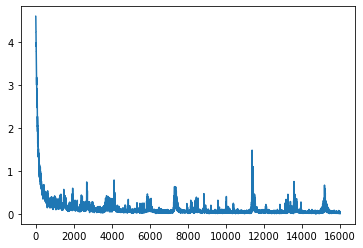

In [5]:
if __name__ == "__main__":
    train_loss, train_best  = main(seed, dim_input, dim_hidden)

In [9]:
# Test the performance
savename = 'Trade_physics11'
model_test = Net(dim_input, dim_hidden, nclass)
model_test.load_state_dict(torch.load( os.path.join(model_dir, 'model-' + savename + '.pt')))
model_test.float()
model_test.eval()
acc_list = scenario_test(scenario, w, rootPath, model_test)
print(acc_list)


testing_sigPQ_perturb_1
Test set results: loss= 0.1084 accuracy= 98.2143 1-hop accuracy = 1.0000
testing_sigPQ_perturb_1.5
Test set results: loss= 0.1973 accuracy= 94.4643 1-hop accuracy = 0.9946
testing_sigPQ_perturb_2
Test set results: loss= 0.5506 accuracy= 84.6429 1-hop accuracy = 0.9357
testing_sigPQ_perturb_3
Test set results: loss= 2.2950 accuracy= 69.8214 1-hop accuracy = 0.8071
[[98.21 94.46 84.64 69.82]]
